In [171]:
from __future__ import division
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import math, sys, glob, re
import scipy.constants as phco

%matplotlib inline

""" geocentric gravitational constant (m^3/s^2) """
GM = 3.986004418e14
""" Earth radius (m) """
Rearth = 6378000
""" Earth rotation (rad/s) """
wE = 7.292e-5

In [188]:
""" Collecting delays """

dataset_number = 0
carrier_code = "ca"      # ["ca", "co"]
frequency_n = "3"        # ["1", "2", "3"], where "1": GS -> ISS; "2" and "3": ISS -> GS

current_path = !pwd
directories = glob.glob(current_path[0] + '/v4.3.2_mb_53896_53907/gs999/*')

if (dataset_number >= len(directories)):
    print "Dataset does not exist! Change dataset_number. \n"

""" Extracting the m. Julian day for the dataset"""
mjd = re.search('%s(.*)%s' % ('mjd','\.'), directories[dataset_number]).group(1)


path = directories[dataset_number] + '/theo/'
#path = current_path[0] + '/v4.3.2_mb_53896_53907/gs999/mjd53897.220682_ch1/theo/'

filename = 'v4.3.2_theo_f' + frequency_n + '_' + carrier_code + '.dat'
data = pd.read_csv(path + filename, delim_whitespace = True, skiprows=1, \
                   names=['time.tag','MJD', 'coord.time', 'prop.time','PToF','geometric.ToF','shapiro','tropo.delay',\
                          'iono.1/f^2', 'iono.1/f^3', 'STEC', 'desynchronisation', 'rangeX', 'rangeY', 'rangeZ', \
                          'sequence.number','Tm'])

data['distance'] = np.sqrt(data['rangeX']**2 + data['rangeY']**2 + data['rangeZ']**2)


""" Collecting ISS positions and velocities """

path = current_path[0] + '/v4.3.2_mb_53896_53907/auxdata/iss/orbit/'
filename = 'v4.3.2_orb_KU_' + mjd
iss_orbit = pd.read_csv(path + filename, delim_whitespace = True, skiprows=1, \
                   names=['julian.day','coord.time', 'x', 'y','z','Vx','Vy','Vz'])


""" Collecting ground station positions and velocities """

path = current_path[0] + '/v4.3.2_mb_53896_53907/auxdata/gs999/orbit/'
filename = 'v4.3.2_orbGS_'  + mjd
gs_orbit = pd.read_csv(path + filename, delim_whitespace = True, skiprows=1, \
                   names=['julian.day','coord.time', 'x', 'y','z','Vx','Vy','Vz'])

def position(dataframe, element=0):
    return np.array([dataframe['x'][element], dataframe['y'][element], dataframe['z'][element]])

def velocity(dataframe, element=0):
    return np.array([dataframe['Vx'][element], dataframe['Vy'][element], dataframe['Vz'][element]])

def unit_vector(vector):
    try:
        normalized = vector/np.linalg.norm(vector)
    except ZeroDivisionError:
        sys.exit("Can't normalize, zero vector!")
    return normalized

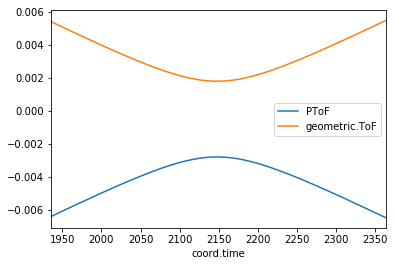

In [189]:
data.plot(x = 'coord.time', y = ['PToF','geometric.ToF'])

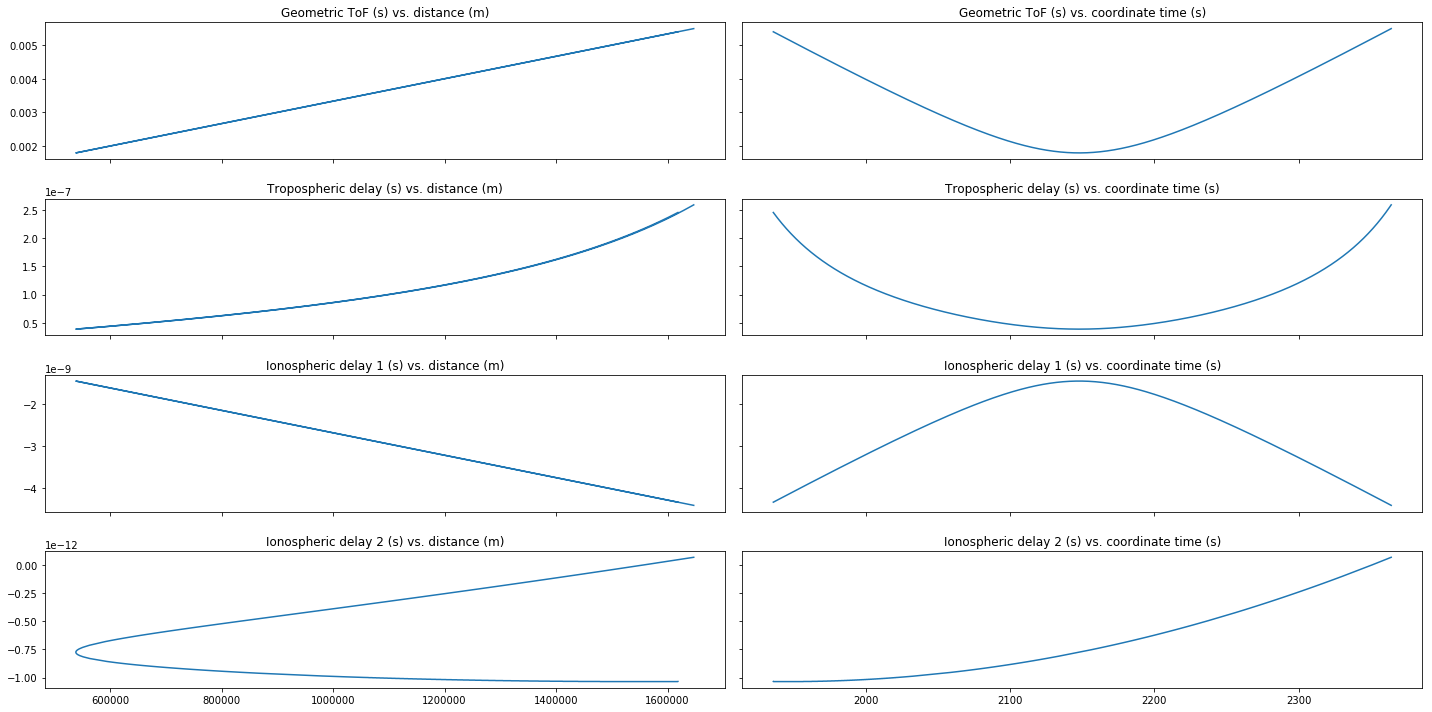

In [190]:
x = data['distance']
x1 = data['coord.time']

fig, plot_array = plt.subplots(4, 2, sharex='col', sharey='row', figsize=(20, 10))

plot_array[0, 0].plot(x, data['geometric.ToF'])
plot_array[0, 0].set_title('Geometric ToF (s) vs. distance (m)')
plot_array[1, 0].plot(x, data['tropo.delay'])
plot_array[1, 0].set_title('Tropospheric delay (s) vs. distance (m)')
plot_array[2, 0].plot(x, data['iono.1/f^2'])
plot_array[2, 0].set_title('Ionospheric delay 1 (s) vs. distance (m)')
plot_array[3, 0].plot(x, data['iono.1/f^3'])
plot_array[3, 0].set_title('Ionospheric delay 2 (s) vs. distance (m)')

plot_array[0, 1].plot(x1, data['geometric.ToF'])
plot_array[0, 1].set_title('Geometric ToF (s) vs. coordinate time (s)')
plot_array[1, 1].plot(x1, data['tropo.delay'])
plot_array[1, 1].set_title('Tropospheric delay (s) vs. coordinate time (s)')
plot_array[2, 1].plot(x1, data['iono.1/f^2'])
plot_array[2, 1].set_title('Ionospheric delay 1 (s) vs. coordinate time (s)')
plot_array[3, 1].plot(x1, data['iono.1/f^3'])
plot_array[3, 1].set_title('Ionospheric delay 2 (s) vs. coordinate time (s)')

plt.tight_layout(h_pad=2.0)

#plot_array[3, 1].xlabel('coordinate time (s)')


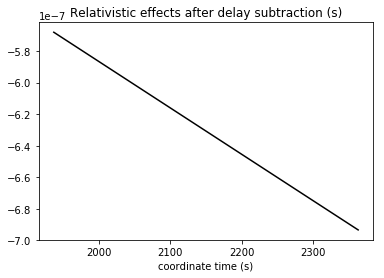

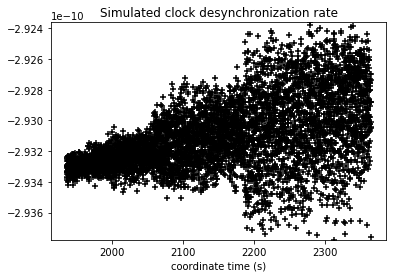

In [191]:
data['test'] = data['geometric.ToF'] + data['tropo.delay'] + data['iono.1/f^2'] + data['iono.1/f^3'] \
               + data['PToF'] + 1e-3*(-1 if frequency_n=="1" else 1)
""" This additional +/- 1ms doesn't really matter, because we'll take a derivative"""
    
fig, ax = plt.subplots()
plt.plot(data['coord.time'], data['test'], c = 'k')
plt.xlabel('coordinate time (s)')
plt.title('Relativistic effects after delay subtraction (s)')
plt.show()

""" Taking derivative of that data """

time_steps_experiment = np.gradient(np.array(data['coord.time']))
data_derivatives = np.gradient(np.array(data['test']))/time_steps_experiment

plt.scatter(data['coord.time'], data_derivatives, c = 'k', marker = '+')
plt.ylim(np.min(data_derivatives), np.max(data_derivatives))

plt.xlabel('coordinate time (s)')
plt.title('Simulated clock desynchronization rate')

In [137]:
""" Forming array of accelerations """

#gs_acceleration = np.array([(velocity(gs_orbit, i+1) - velocity(gs_orbit, i))/(gs_orbit['coord.time'][i] - gs_orbit['coord.time'][i+1]) for i in range(gs_orbit.shape[0]-1)])
#last_element = gs_acceleration[-1] + (gs_orbit['coord.time'].iloc[-1] - gs_orbit['coord.time'].iloc[-2])*(gs_acceleration[-1] - gs_acceleration[-2])/(gs_orbit['coord.time'].iloc[-2] - gs_orbit['coord.time'].iloc[-3])
#gs_acceleration = np.append(gs_acceleration, [last_element], axis=0)

""" Forming array of time steps and preparing it for broadcasting """
time_steps = np.gradient(np.array(gs_orbit['coord.time']))
time_steps_vectorized = np.array([time_steps,]*3).T
gs_velocity = velocity(gs_orbit, np.arange(gs_orbit.shape[0])).T
#np.array([velocity(gs_orbit, i) for i in range(gs_orbit.shape[0])])

""" For 1 sec time step one could drop the time steps, but we'll keep them for compatibility"""

gs_acceleration = np.gradient(gs_velocity, axis = 0)/time_steps_vectorized

assert gs_acceleration.shape[0] == gs_orbit.shape[0]

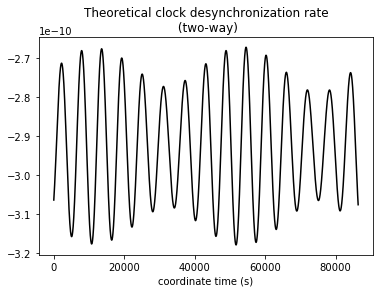

Average calculated desynchronization: -2.9242655874844355e-10
Experimental desynchronization: -2.931069721756393e-10


In [138]:
""" Two-way relativistic effect """

def relativistic_effect(i):
    assert gs_orbit.shape == iss_orbit.shape
    potential_difference = GM*(1/np.linalg.norm(position(gs_orbit, i)) - 1/np.linalg.norm(position(iss_orbit, i)))/(phco.c**2)
    second_doppler = -.5*(np.linalg.norm(velocity(gs_orbit, i)-velocity(iss_orbit, i))/phco.c)**2
    acceleration_term = - np.dot(position(gs_orbit, i)-position(iss_orbit, i), gs_acceleration[i])/(phco.c**2)
    first_doppler = np.dot(unit_vector(position(gs_orbit, i)-position(iss_orbit, i)), velocity(gs_orbit, i)-velocity(iss_orbit, i))/phco.c
    return (potential_difference + second_doppler + acceleration_term)*(1 + first_doppler)

relativistic_array = [relativistic_effect(i) for i in range(gs_orbit.shape[0])]

fig, ax = plt.subplots()
plt.plot(gs_orbit['coord.time'], relativistic_array, c = 'k')
plt.xlabel('coordinate time (s)')
plt.title('Theoretical clock desynchronization rate\n (two-way)')
plt.show()

# periodicity should be about 5520 s due to the 92 min ISS revolution period

print 'Average calculated desynchronization: ' + str(np.mean(relativistic_array))
print 'Experimental desynchronization: ' + str((data['test'][-1]-data['test'][0])/(data['prop.time'][-1]-data['prop.time'][0]))

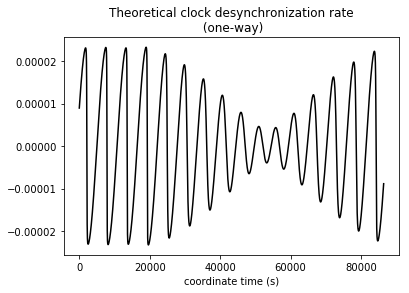

Average calculated desynchronization: -1.9802709653103092e-09
Experimental desynchronization: -2.931069721756393e-10


In [127]:
""" One-way relativistic effect, precision 1/c^3 """

def relativistic_effect(i):
    assert gs_orbit.shape == iss_orbit.shape
    
    r_A = position(iss_orbit, i)
    r_B = position(gs_orbit, i)
    
    abs_r_A = np.linalg.norm(r_A)
    abs_r_B = np.linalg.norm(r_B)
    R_AB = r_B - r_A
    abs_R_AB = np.linalg.norm(R_AB)
    N_AB = R_AB/abs_R_AB
    
    v_A = velocity(iss_orbit, i)
    v_B = velocity(gs_orbit, i)
    abs_v_A = np.linalg.norm(v_A)
    abs_v_B = np.linalg.norm(v_B)

    
#    potential_difference = GM*(1/abs_r_B - 1/abs_r_A)/(phco.c**2)
#    second_doppler = +.5*(abs_v_B**2 - abs_v_A**2)/(phco.c**2)
#    first_doppler_iss = np.dot(N_AB, v_A)/phco.c
#    first_doppler_gs = np.dot(N_AB, v_B)/phco.c
    
    common_factor = (4*GM/(phco.c**3))/((abs_r_A + abs_r_B)**2 - (abs_R_AB)**2)
    q_A = 1 - np.dot(N_AB, v_A)/phco.c - common_factor*((abs_r_A + abs_r_B)*np.dot(N_AB, v_A) + abs_R_AB*np.dot(r_A, v_A)/abs_r_A)
    q_B = 1 - np.dot(N_AB, v_B)/phco.c - common_factor*((abs_r_A + abs_r_B)*np.dot(N_AB, v_B) - abs_R_AB*np.dot(r_B, v_B)/abs_r_B)

    return 1-(q_A/q_B)*(1 - (GM/abs_r_B + 0.5*abs_v_B**2)/(phco.c**2))/(1 - (GM/abs_r_A + 0.5*abs_v_A**2)/(phco.c**2))
#    return - potential_difference - second_doppler

relativistic_array = [relativistic_effect(i) for i in range(gs_orbit.shape[0])]

fig, ax = plt.subplots()
plt.plot(gs_orbit['coord.time'], relativistic_array, c = 'k')
plt.xlabel('coordinate time (s)')
plt.title('Theoretical clock desynchronization rate\n (one-way)')
plt.show()

# periodicity should be about 5520 s due to the 92 min ISS revolution period

print 'Average calculated desynchronization: ' + str(np.mean(relativistic_array))
print 'Experimental desynchronization: ' + str((data['test'][-1]-data['test'][0])/(data['prop.time'][-1]-data['prop.time'][0]))

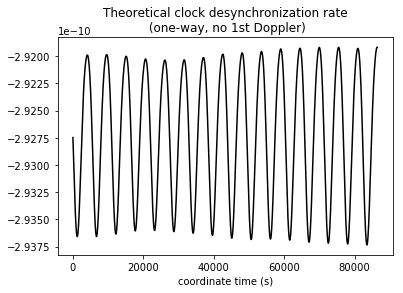

Average calculated desynchronization: -2.9273595650968675e-10
Experimental desynchronization: -2.9310712121189386e-10


In [192]:
""" One-way relativistic effect without 1st order Doppler, precision 1e-13 """

def relativistic_effect_c_square(i):
    assert gs_orbit.shape == iss_orbit.shape
    potential_difference = GM*(1/np.linalg.norm(position(gs_orbit, i)) - 1/np.linalg.norm(position(iss_orbit, i)))/(phco.c**2)
    second_doppler = +.5*(np.linalg.norm(velocity(gs_orbit, i))**2 - np.linalg.norm(velocity(iss_orbit, i))**2)/(phco.c**2)
    first_doppler_iss = np.dot(unit_vector(position(gs_orbit, i)-position(iss_orbit, i)), velocity(iss_orbit, i))/phco.c
    first_doppler_gs = np.dot(unit_vector(position(gs_orbit, i)-position(iss_orbit, i)), velocity(gs_orbit, i))/phco.c
    return potential_difference + second_doppler

relativistic_array_c_square = [relativistic_effect_c_square(i) for i in range(gs_orbit.shape[0])]

fig, ax = plt.subplots()
plt.plot(gs_orbit['coord.time'], relativistic_array_c_square, c = 'k')
plt.xlabel('coordinate time (s)')
plt.title('Theoretical clock desynchronization rate\n (one-way, no 1st Doppler)')
plt.show()

# periodicity should be about 5520 s due to the 92 min ISS revolution period

print 'Average calculated desynchronization: ' + str(np.mean(relativistic_array_c_square))
print 'Experimental desynchronization: ' + str((data['test'][-1]-data['test'][0])/(data['prop.time'][-1]-data['prop.time'][0]))

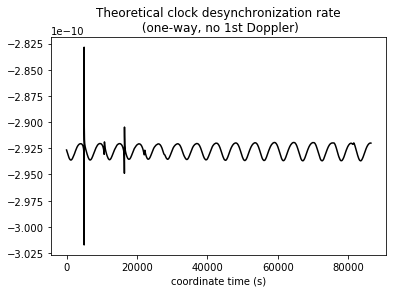

In [195]:
""" One-way relativistic effect without 1st order Doppler, precision 1/c^3 """

def relativistic_effect(i, lower_precision = False):
    assert gs_orbit.shape == iss_orbit.shape
    
    r_A = position(iss_orbit, i)
    r_B = position(gs_orbit, i)
    
    abs_r_A = np.linalg.norm(r_A)
    abs_r_B = np.linalg.norm(r_B)
    R_AB = r_B - r_A
    abs_R_AB = np.linalg.norm(R_AB)
    N_AB = R_AB/abs_R_AB
    
    v_A = velocity(iss_orbit, i)
    v_B = velocity(gs_orbit, i)
    abs_v_A = np.linalg.norm(v_A)
    abs_v_B = np.linalg.norm(v_B)
    
#    potential_difference = GM*(1/abs_r_B - 1/abs_r_A)/(phco.c**2)
#    second_doppler = +.5*(abs_v_B**2 - abs_v_A**2)/(phco.c**2)
#    first_doppler_iss = np.dot(N_AB, v_A)/phco.c
#    first_doppler_gs = np.dot(N_AB, v_B)/phco.c
    
    common_factor = (4*GM/(phco.c**3))/((abs_r_A + abs_r_B)**2 - (abs_R_AB)**2)
    
    """ Here one can lower precision to 1/c^2, if needed """
    if lower_precision:
        q_A = q_B = 1
    else:
        q_A = 1 - common_factor*((abs_r_A + abs_r_B)*np.dot(N_AB, v_A) + abs_R_AB*np.dot(r_A, v_A)/abs_r_A)
        q_B = 1 - common_factor*((abs_r_A + abs_r_B)*np.dot(N_AB, v_B) - abs_R_AB*np.dot(r_B, v_B)/abs_r_B)

    result = 1 - (q_A/q_B)*(1 - (GM/abs_r_B + 0.5*abs_v_B**2)/(phco.c**2))/(1 - (GM/abs_r_A + 0.5*abs_v_A**2)/(phco.c**2))
    
    return result*(-1 if frequency_n=="1" else 1)


relativistic_array_c_cube = [relativistic_effect(i) for i in range(gs_orbit.shape[0])]
relativistic_array_c_square = [relativistic_effect(i, lower_precision=True) for i in range(gs_orbit.shape[0])]


fig, ax = plt.subplots()
plt.plot(gs_orbit['coord.time'], relativistic_array_c_cube, c = 'k')
plt.xlabel('coordinate time (s)')
plt.title('Theoretical clock desynchronization rate\n (one-way, no 1st Doppler)')
plt.show()

# periodicity should be about 5520 s due to the 92 min ISS revolution period

#print 'Average calculated desynchronization: ' + str(np.mean(relativistic_array))
#print 'Experimental desynchronization: ' + str((data['test'][-1]-data['test'][0])/(data['prop.time'][-1]-data['prop.time'][0]))

Coordinate time: 1935.0
potential_difference: 3.642202189036365e-11
second_doppler: -3.0844338482212676e-10
first_doppler: -2.2569860510770093e-05


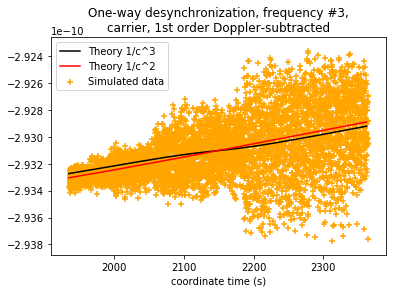

In [196]:
""" TEST """

""" Assuming 1 sec time steps """

t_first = int(data['coord.time'][0])
t_last = int(data['coord.time'][-1])

i = t_first
potential_difference = GM*(1/np.linalg.norm(position(gs_orbit, i)) - 1/np.linalg.norm(position(iss_orbit, i)))/(phco.c**2)
second_doppler = -.5*(np.linalg.norm(velocity(gs_orbit, i)-velocity(iss_orbit, i))/phco.c)**2
#acceleration_term = - np.dot(position(gs_orbit, i)-position(iss_orbit, i), gs_acceleration[i])/(phco.c**2)
first_doppler = np.dot(unit_vector(position(gs_orbit, i)-position(iss_orbit, i)), velocity(gs_orbit, i)-velocity(iss_orbit, i))/phco.c

print 'Coordinate time: ' + str(gs_orbit['coord.time'].iloc[i])
print 'potential_difference: '+ str(potential_difference)
print 'second_doppler: '+ str(second_doppler)
#print 'acceleration_term: '+ str(acceleration_term)
print 'first_doppler: '+ str(first_doppler)

#print 'Theoretical desynchronization \n'+ str((potential_difference + second_doppler + acceleration_term)*(1 + first_doppler))

#plt.plot(np.array(gs_orbit['coord.time'][t_first:t_last]), relativistic_array[t_first:t_last], c = 'k')
#plt.title('Theoretical desynchronization')

plt.plot(np.array(gs_orbit['coord.time'][t_first:t_last]), relativistic_array_c_cube[t_first:t_last], c = 'k')
plt.plot(np.array(gs_orbit['coord.time'][t_first:t_last]), relativistic_array_c_square[t_first:t_last], c = 'r')
plt.scatter(data['coord.time'], data_derivatives, c = 'orange', marker = '+')
plt.ylim(np.min(data_derivatives) - 1e-13, np.max(data_derivatives) + 1e-13)
plt.legend(["Theory 1/c^3", "Theory 1/c^2", "Simulated data"])
plt.title('One-way desynchronization, frequency #' + frequency_n + ',\n' + ("carrier" if carrier_code=="ca" else "code") + ', 1st order Doppler-subtracted')
plt.xlabel('coordinate time (s)')

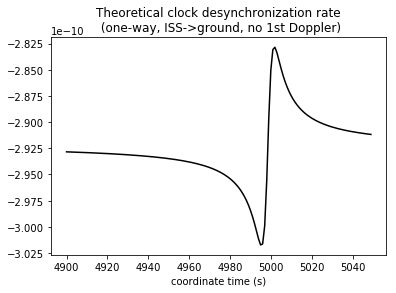

In [119]:


begin_time = 4900
end_time = 5050
fig, ax = plt.subplots()
plt.plot(gs_orbit['coord.time'][begin_time:end_time], relativistic_array[begin_time:end_time], c = 'k')
plt.xlabel('coordinate time (s)')
plt.title('Theoretical clock desynchronization rate\n (one-way, no 1st Doppler)')
plt.show()

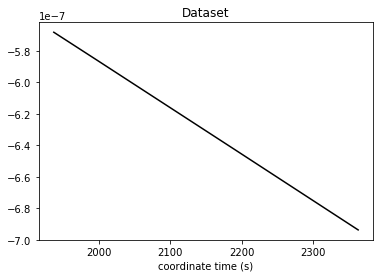

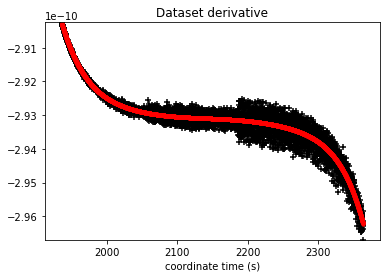

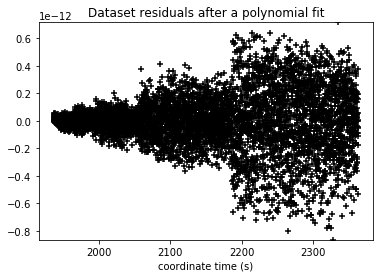

In [100]:
""" Here we're checking, where the step-like noise in the desynchronization is coming from """

data['test'] = data['geometric.ToF'] + data['tropo.delay'] + data['iono.1/f^2'] + data['iono.1/f^3'] \
               + data['PToF'] + 1e-3
    
""" Ionosphere doesn't contribute to the steps, let's play with troposhpere """
data['test1'] = data['geometric.ToF'] + 0.999*data['tropo.delay'] + data['PToF'] + 1e-3
    
set_name = 'test1'

fig, ax = plt.subplots()
plt.plot(data['coord.time'], data[set_name], c = 'k')
plt.xlabel('coordinate time (s)')
plt.title('Dataset')
plt.show()

""" Taking derivative of that data """

time_steps_experiment = np.gradient(np.array(data['coord.time']))
data_derivatives = np.gradient(np.array(data[set_name]))/time_steps_experiment
fit_data = np.polyfit(data['coord.time'], data_derivatives, 7)
y_fit = np.polyval(fit_data, data['coord.time'])
residuals = data_derivatives - y_fit

plt.scatter(data['coord.time'], data_derivatives, c = 'k', marker = '+')
plt.scatter(data['coord.time'], y_fit, c = 'r', marker = '.')
plt.ylim(np.min(data_derivatives), np.max(data_derivatives))
plt.xlabel('coordinate time (s)')
plt.title('Dataset derivative')
plt.show()

plt.scatter(data['coord.time'], residuals, c = 'k', marker = '+')
plt.ylim(np.min(residuals), np.max(residuals))
plt.title('Dataset residuals after a polynomial fit')
plt.xlabel('coordinate time (s)')
plt.show()

""" Some general shape fitting: """

from scipy.optimize import curve_fit

def fit_function(x, x0, c1, c2):
    y = c1*np.arctan(c2*(x-x0))
    return y

popt, pcov = curve_fit(fit_function, data['coord.time'], data_derivatives)
y_fit = fit_function(data['coord.time'], *popt)
residuals = data_derivatives - y_fit